In [21]:
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
import pymaster as nmt
import sys
sys.path.append('../')

# from scripts.compute_decoupled_cl import compute_decoupled_cl
from scripts.compute_weights import compute_weights
from scripts.compute_alm_ilc import compute_alm_ilc
from scripts.mask_maps import mask_maps
from scripts.cosine_smoothed_mask import cosine_smoothed_mask
from scripts.generate_noise import generate_noise
from scripts.sigma_noise import sigma_noise

### Load Smoothed, Contaminated HI maps

In [23]:
smoothed_maps=np.load("smoothed_maps_1_smallbeam.npy")
smoothed_hi_maps=np.load("smoothed_hi_maps.npy")

### Generate Noise

In [24]:
mask = cosine_smoothed_mask(nside)
mask= (mask*(-1))+1
fsky=np.mean(mask)
print(fsky)
sigma=sigma_noise(nside, fsky)
noise=generate_noise(nside, sigma, nfreqs)
print(noise.shape)
print(sigma)

0.10448023039132469
(5, 786432)
0.00013353386332107953


In [25]:
def add_noise(maps_in, noise_maps, nfreqs, lmax, almsize):
    """
    Add noise to the input maps.

    Args:
        maps_in (np.ndarray): input smoothed and masked maps
        noise_maps (np.ndarray): gaussian noise maps

    Returns:
        noisy_maps (np.ndarray)
        noisy_als (np.ndarray)
    """
    # almsize= hp.Alm.getsize(lmax-2)
    noisy_maps= maps_in+ noise_maps
    noisy_alms=np.zeros((nfreqs, almsize), dtype=complex)
    for nf in range(nfreqs):
        noisy_alms[nf,:] = hp.map2alm(noisy_maps[nf,:], lmax=lmax-2)
    
    return noisy_maps, noisy_alms

### Run HILC

In [22]:
nside=256
factor=1e7

# freqs=np.arange(544,1088,step=1)
nfreqs=5
# shells= nfreqs-1
lmax=3*nside -1
D=13.5 #size of dish in meteres

In [26]:
def compute_decoupled_cl( maps: np.ndarray, masks:np.ndarray, X:bool, nsides:int, lmax:int, n_freq:int)-> np.ndarray:
    """
    Compute the power spectra using NaMaster for a set of frequency maps.

    Parameters:
    - maps: numpy array of shape (n_freqs, n_maps) containing the frequency maps
    - masks: mask to apply to the maps
    - X: flag to indicate if the input maps are masked
    - nsides: resolution parameter for the maps
    - l_max: maximum multipole for the power spectra
    - n_freq: number of frequency channels

    Returns:

    - cldec: decoupled power spectrum
    """
    p_cl =np.zeros((lmax+1, n_freq, n_freq))
    cldec = np.zeros((lmax+1, n_freq, n_freq))
    

    # Loop over all pairs of frequency maps (cross-power spectra)
    for i in range(n_freq):
        print(f"Decoupling map {i}")
        for j in range(i, n_freq):  # Compute only upper triangle (symmetric matrix)

            # Define the masked fields for the two maps
            f_i = nmt.NmtField(1 - masks, [maps[i, :]], masked_on_input=X) 
            f_j = nmt.NmtField(1 - masks, [maps[j, :]], masked_on_input=X) 

            # Compute the coupled power spectrum for (i, j)
            p_cl[:, i, j] = nmt.compute_coupled_cell(f_i, f_j)
            


            # Define a NaMaster binning scheme (no binning)
            b = nmt.NmtBin.from_nside_linear(nsides, 1)

            # Create NaMaster workspace and get the coupling matrix
            w = nmt.NmtWorkspace.from_fields(f_i, f_j, b)
            #w = nmt.NmtWorkspace()
            w.compute_coupling_matrix(f_i, f_j, b)
        
            #w.compute(f_i, f_j, b)
            matrix = w.get_coupling_matrix() #lxl

            # Compute the inverse of the mode-coupling matrix
            matrix_inv = np.linalg.pinv(matrix, rcond=1e-6)

            # Compute the decoupled power spectrum using Einstein summation
            cldec[:, i, j] = np.einsum('ij,j->i', matrix_inv, p_cl[:, i, j])
            # cldec[2:,i,j] = nmt.compute_full_master(f_i, f_j, b)

            # Since Cl is symmetric, copy the value to (j, i)
            if i != j:
                cldec[:, j, i] = cldec[:, i, j]
                p_cl[:, j, i] = p_cl[:, i, j]
    return cldec

In [27]:
def compute_master (maps: np.ndarray, masks:np.ndarray, X:bool, nsides:int, l_max:int, n_freq:int)-> np.ndarray:

    cldec = np.zeros((lmax-1, n_freq, n_freq))
    

    # Loop over all pairs of frequency maps (cross-power spectra)
    for i in range(n_freq):
        print(f"Decoupling map {i}")
        for j in range(i, n_freq):  # Compute only upper triangle (symmetric matrix)

            # Define the masked fields for the two maps
            f_i = nmt.NmtField(1 - masks, [maps[i, :]], masked_on_input=X, lmax=l_max) 
            f_j = nmt.NmtField(1 - masks, [maps[j, :]], masked_on_input=X, lmax=l_max) 
            
            # Define a NaMaster binning scheme (no binning)
            b = nmt.NmtBin.from_nside_linear(nsides, 1)

            cldec[:,i,j] = nmt.compute_full_master(f_i, f_j, b)
            

            # Since Cl is symmetric, copy the value to (j, i)
            if i != j:
                cldec[:, j, i] = cldec[:, i, j]
                
    return cldec

Compute decooupled power spectra for first 30 frequencies

In [29]:
cl_dec= compute_master(smoothed_hi_maps[:nfreqs], mask, False, nside, lmax, nfreqs)

Decoupling map 0
Decoupling map 1
Decoupling map 2
Decoupling map 3
Decoupling map 4


In [30]:
print(cl_dec.shape)

(766, 5, 5)


In [31]:
npix= hp.nside2npix(nside)
alm_size=hp.Alm.getsize(lmax-2)

In [ ]:
_, weights = compute_weights(nfreqs, lmax-2, cl_dec)
masked_maps, alms_masked= mask_maps(smoothed_hi_maps[:nfreqs], mask, alm_size,lmax-2, nfreqs, npix)
# _, noisy_alms=add_noise(masked_maps, noise)
alm_ilc=compute_alm_ilc(alms_masked, alm_size, weights, lmax-2)
clean_maps = hp.alm2map(alm_ilc, nside, lmax=lmax-2, mmax=None)

In [33]:
clean_maps=np.tile(clean_maps, (1, nfreqs))
clean_maps = clean_maps.reshape(nfreqs, npix)
print(clean_maps.shape)

(5, 786432)


In [34]:
hilc_dec= compute_master(clean_maps, mask, True, nside, lmax,nfreqs)

Decoupling map 0
Decoupling map 1
Decoupling map 2
Decoupling map 3
Decoupling map 4


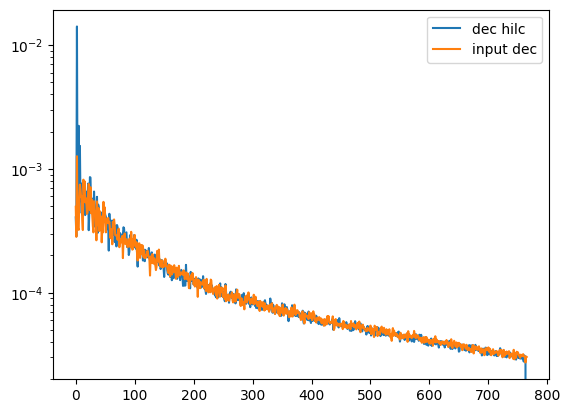

In [35]:
input= hp.anafast(smoothed_hi_maps[0])
plt.plot(hilc_dec[:,0,0]*nfreqs,label="dec hilc")
plt.plot(cl_dec[:,0,0], label="input dec")
# plt.plot(input[2:], label="input maps")
plt.yscale("log")
plt.legend()


In [36]:
weights.shape

(5, 766)

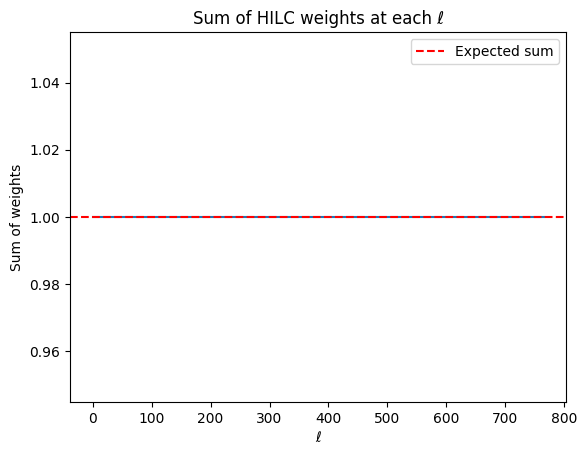

In [37]:
weight_sums = np.sum(weights, axis=0)
plt.plot(weight_sums)
plt.axhline(1.0, color='r', linestyle='--', label='Expected sum')
plt.xlabel('ℓ')
plt.ylabel('Sum of weights')
plt.title('Sum of HILC weights at each ℓ')
plt.legend()
plt.show()

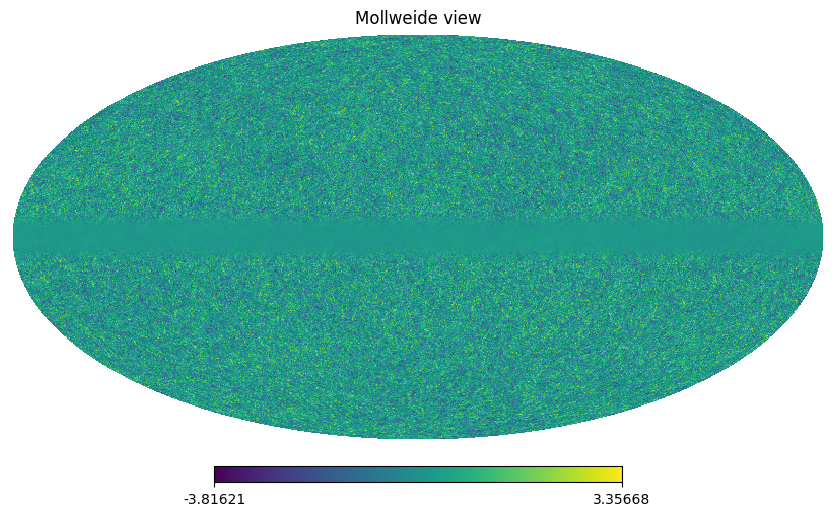

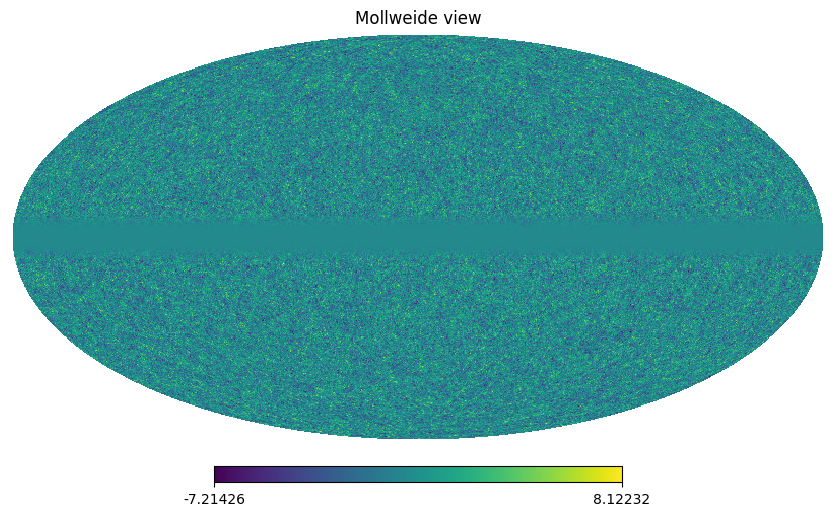

In [39]:
hp.mollview(clean_maps[0])
# hp.mollview(all_maps[0])
hp.mollview((1-mask)*smoothed_hi_maps[0])

With foregounds

In [43]:
def apply_HILC(map_in:np.ndarray, nside, n_freqs)->np.ndarray:
    
    """
    Applies the HILC algorithim to input maps
    
    Parameters:
        map_in (np.ndarray): input maps

    Returns:
        clean_maps (np.ndarray): _description_
    """
    npix= hp.nside2npix(nside)

    alm_size=hp.Alm.getsize(lmax-2)

        
    # Generate and plot the mask
    mask = cosine_smoothed_mask(nside)
    mask= (mask*(-1))+1
    cl_dec=compute_master(map_in, mask,False, nside, lmax, n_freqs)
    _, weights = compute_weights(n_freqs, lmax-2, cl_dec)
    masked_maps, alm_masked= mask_maps(map_in, mask, alm_size,lmax-2, n_freqs, npix)
    # _, noisy_alms=add_noise(masked_maps, noise, nfreqs, lmax, alm_size)
    alm_ilc=compute_alm_ilc(alm_masked, alm_size, weights, lmax)
    clean_maps = hp.alm2map(alm_ilc, nside, lmax=lmax-2, mmax=None)
    clean_maps=np.tile(clean_maps, (1, n_freqs))
    clean_maps = clean_maps.reshape(n_freqs, npix)
    print("Cleaned Maps")
    return clean_maps

In [40]:
dec_in= compute_master(smoothed_maps, mask, False, nside, lmax, nfreqs)

Decoupling map 0
Decoupling map 1
Decoupling map 2
Decoupling map 3
Decoupling map 4


In [41]:
smoothed_maps.shape

(181, 786432)

In [ ]:
cleanmaps=apply_HILC(smoothed_maps[:nfreqs], nside,nfreqs)
hilc= compute_master(cleanmaps, mask, True, nside, lmax, nfreqs)

Decoupling map 0
Decoupling map 1
Decoupling map 2
Decoupling map 3
Decoupling map 4


IndexError: index 293811 is out of bounds for axis 1 with size 293761

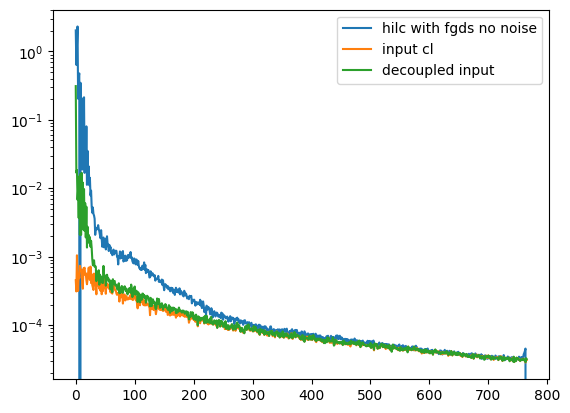

In [ ]:
plt.plot(hilc[:,0,0]*nfreqs, label="hilc with fgds no noise")
plt.plot(input[2:], label="input cl")
plt.plot(dec_in[:,0,0], label="decoupled input")
plt.yscale("log")
plt.legend()